In [23]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3

# Webscraping Books Data

In [14]:
# URL of the website to scrape
url = "http://books.toscrape.com/"

# Send a GET request to fetch the page
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract data: Book Title, Price, Availability, Rating, URL, Image URL
books = []
for book in soup.find_all('article', class_='product_pod'):
    title = book.h3.a['title']
    price = book.find('p', class_='price_color').text
    availability = book.find('p', class_='instock availability').text.strip()
    rating = book.p['class'][1]  # Extract the rating class (e.g., "three", "four")
    url = book.h3.a['href']
    image_url = book.find('img')['src']

    books.append({
        'title': title,
        'price': price,
        'availability': availability,
        'rating': rating,
        'url': url,
        'image_url': image_url
    })

# Convert to DataFrame for easy processing
df = pd.DataFrame(books)

# Display the DataFrame
df.head()

,title,price,availability,rating,url,image_url
0,A Light in the Attic,Â£51.77,In stock,Three,catalogue/a-light-in-the-attic_1000/index.html,media/cache/2c/da/2cdad67c44b002e7ead0cc35693c...
1,Tipping the Velvet,Â£53.74,In stock,One,catalogue/tipping-the-velvet_999/index.html,media/cache/26/0c/260c6ae16bce31c8f8c95daddd9f...
2,Soumission,Â£50.10,In stock,One,catalogue/soumission_998/index.html,media/cache/3e/ef/3eef99c9d9adef34639f51066202...
3,Sharp Objects,Â£47.82,In stock,Four,catalogue/sharp-objects_997/index.html,media/cache/32/51/3251cf3a3412f53f339e42cac213...
4,Sapiens: A Brief History of Humankind,Â£54.23,In stock,Five,catalogue/sapiens-a-brief-history-of-humankind...,media/cache/be/a5/bea5697f2534a2f86a3ef27b5a8c...


In [2]:
## Data cleaning and preprocessing

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         20 non-null     object
 1   price         20 non-null     object
 2   availability  20 non-null     object
 3   rating        20 non-null     object
 4   url           20 non-null     object
 5   image_url     20 non-null     object
dtypes: object(6)
memory usage: 1.1+ KB


In [16]:
df.isnull().sum()

,0
title,0
price,0
availability,0
rating,0
url,0
image_url,0


In [17]:
# Remove currency symbol and any unwanted characters, then convert to float
df['price'] = df['price'].replace('£', '', regex=True)  # Remove the £ symbol
df['price'] = df['price'].replace(r'[^\d\.]', '', regex=True)  # Remove any non-numeric characters (e.g., Â)
df['price'] = df['price'].astype(float)  # Convert the cleaned string to float

# Transformation


In [18]:
print(df['rating'].unique())

['Three' 'One' 'Four' 'Five' 'Two']


In [19]:
# Convert the ratings to numerical values (for example: one -> 1, two -> 2, etc.)
rating_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
df['rating'] = df['rating'].map(rating_map)

In [20]:
# Categorize books based on price
def price_category(price):
    if price < 10:
        return 'Low'
    elif price < 20:
        return 'Medium'
    else:
        return 'High'

df['price_category'] = df['price'].apply(price_category)

In [21]:
df.head()

,title,price,availability,rating,url,image_url,price_category
0,A Light in the Attic,51.77,In stock,3,catalogue/a-light-in-the-attic_1000/index.html,media/cache/2c/da/2cdad67c44b002e7ead0cc35693c...,High
1,Tipping the Velvet,53.74,In stock,1,catalogue/tipping-the-velvet_999/index.html,media/cache/26/0c/260c6ae16bce31c8f8c95daddd9f...,High
2,Soumission,50.10,In stock,1,catalogue/soumission_998/index.html,media/cache/3e/ef/3eef99c9d9adef34639f51066202...,High
3,Sharp Objects,47.82,In stock,4,catalogue/sharp-objects_997/index.html,media/cache/32/51/3251cf3a3412f53f339e42cac213...,High
4,Sapiens: A Brief History of Humankind,54.23,In stock,5,catalogue/sapiens-a-brief-history-of-humankind...,media/cache/be/a5/bea5697f2534a2f86a3ef27b5a8c...,High


# Loading data into the Database

In [26]:
# Load the DataFrame into an SQLite database
conn = sqlite3.connect('books.db')
df.to_sql('books', conn, if_exists='replace', index=False)
# Verify that the data is inserted into the database
query = "SELECT * FROM books LIMIT 5"
result = pd.read_sql(query, conn)
print(result)
# Close the database connection
conn.close()

                                   title  price availability  rating  \
0                   A Light in the Attic  51.77     In stock       3   
1                     Tipping the Velvet  53.74     In stock       1   
2                             Soumission  50.10     In stock       1   
3                          Sharp Objects  47.82     In stock       4   
4  Sapiens: A Brief History of Humankind  54.23     In stock       5   

                                                 url  \
0     catalogue/a-light-in-the-attic_1000/index.html   
1        catalogue/tipping-the-velvet_999/index.html   
2                catalogue/soumission_998/index.html   
3             catalogue/sharp-objects_997/index.html   
4  catalogue/sapiens-a-brief-history-of-humankind...   

                                           image_url price_category  
0  media/cache/2c/da/2cdad67c44b002e7ead0cc35693c...           High  
1  media/cache/26/0c/260c6ae16bce31c8f8c95daddd9f...           High  
2  media/cache/3e/ef

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
# Load the data from the SQLite database
conn = sqlite3.connect('books.db')
query = "SELECT * FROM books"
df_from_db = pd.read_sql(query, conn)
# Verify the data structure
print(df_from_db.head())
# Close the database connection
conn.close()

                                   title  price availability  rating  \
0                   A Light in the Attic  51.77     In stock       3   
1                     Tipping the Velvet  53.74     In stock       1   
2                             Soumission  50.10     In stock       1   
3                          Sharp Objects  47.82     In stock       4   
4  Sapiens: A Brief History of Humankind  54.23     In stock       5   

                                                 url  \
0     catalogue/a-light-in-the-attic_1000/index.html   
1        catalogue/tipping-the-velvet_999/index.html   
2                catalogue/soumission_998/index.html   
3             catalogue/sharp-objects_997/index.html   
4  catalogue/sapiens-a-brief-history-of-humankind...   

                                           image_url price_category  
0  media/cache/2c/da/2cdad67c44b002e7ead0cc35693c...           High  
1  media/cache/26/0c/260c6ae16bce31c8f8c95daddd9f...           High  
2  media/cache/3e/ef

In [28]:
# Data Exploration and Visualization

In [29]:
## Distribution of Book Prices

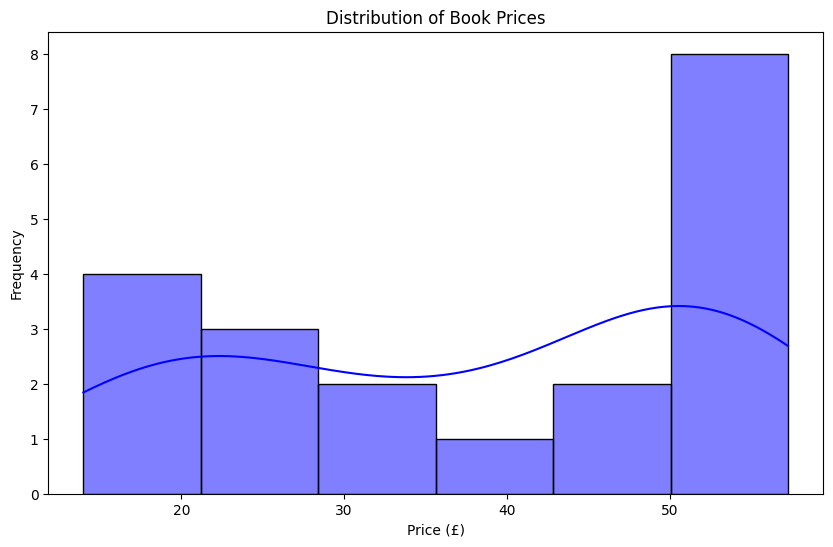

In [30]:
# Plotting the distribution of book prices
plt.figure(figsize=(10, 6))
sns.histplot(df_from_db['price'], kde=True, color='blue')
plt.title('Distribution of Book Prices')
plt.xlabel('Price (£)')
plt.ylabel('Frequency')
plt.show()

In [31]:
## Top 10 Most Expensive Books

<ipython-input-32-ec060c8e9616>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price', y='title', data=top_10_expensive_books, palette='viridis')


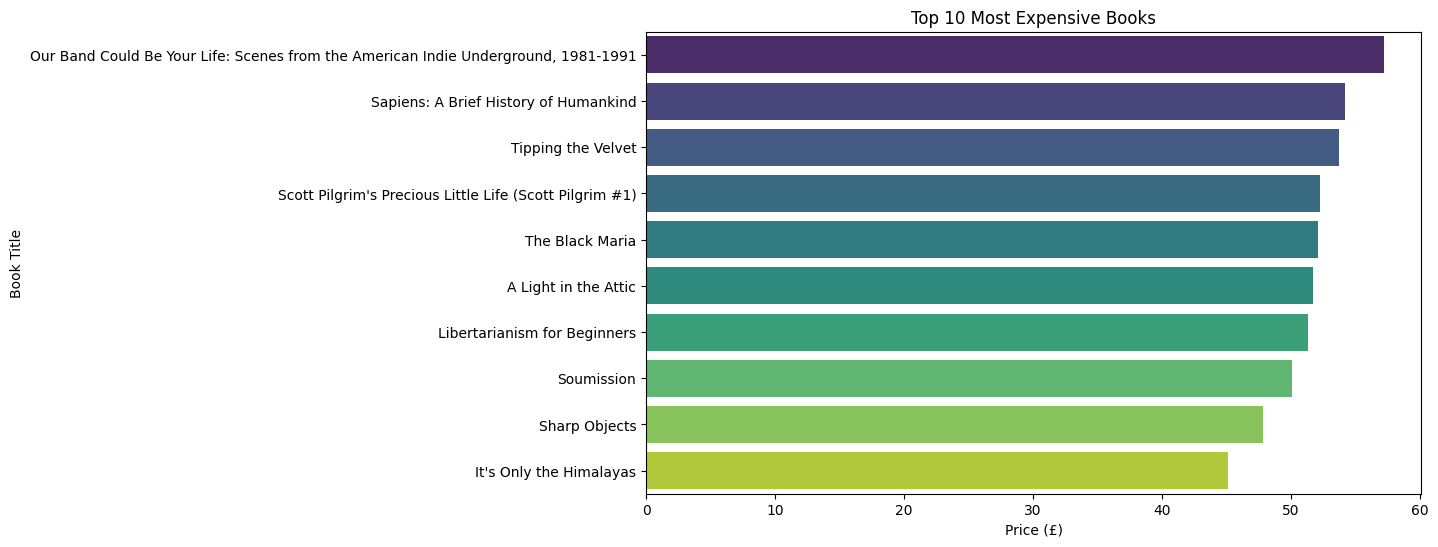

In [32]:
# Sorting books by price in descending order and selecting the top 10
top_10_expensive_books = df_from_db.sort_values(by='price', ascending=False).head(10)

# Plotting the top 10 most expensive books
plt.figure(figsize=(10, 6))
sns.barplot(x='price', y='title', data=top_10_expensive_books, palette='viridis')
plt.title('Top 10 Most Expensive Books')
plt.xlabel('Price (£)')
plt.ylabel('Book Title')
plt.show()


In [33]:
## Rating Distribution of Books

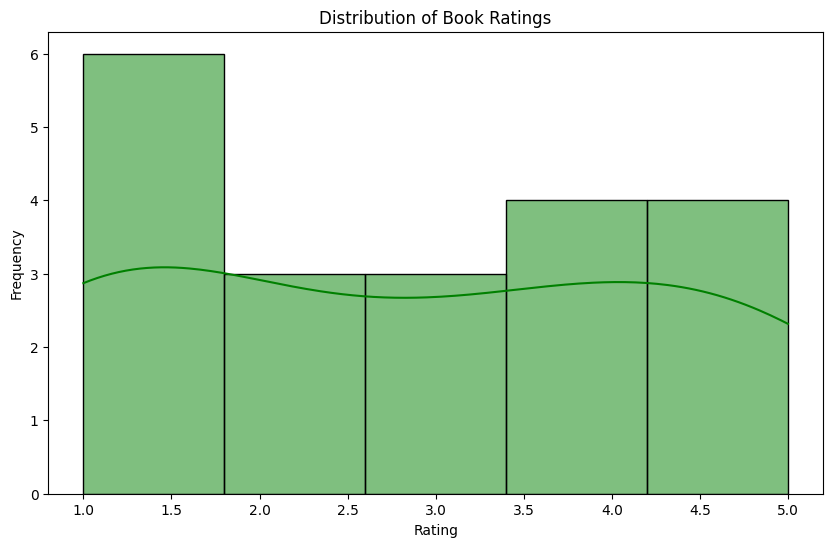

In [35]:
# Plotting the distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(df_from_db['rating'], kde=True, color='green', bins=5)
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()
